In [561]:
import numpy as np
import pandas as pd
import load_raw_data as lrd
from transforms3d import euler
from utils import nearest
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(color_codes=True)
%matplotlib notebook

In [496]:
def parse_dates(timestamp):
    """
    parse_dates(timestampstring) takes a timestamp string formatted as Year-month-dayThour:min:sec.decimals+Timezone
    and converts it into a datetime.datetime format, ignoring the timezone and the last decimal, keeping a microsecond
    precision.
    """
    return pd.datetime.strptime(timestamp[:26], '%Y-%m-%dT%H:%M:%S.%f')


In [498]:
filepath = './Data/Pilot/Jesse_FirstPilot/head.csv'
hd = lrd.load_head_data(filepath)

In [499]:
hd.head()

,Value.M11,Value.M12,Value.M13,Value.M14,Value.M21,Value.M22,Value.M23,Value.M24,Value.M31,Value.M32,Value.M33,Value.M34,Value.M41,Value.M42,Value.M43,Value.M44
Timestamp,,,,,,,,,,,,,,,,
2017-08-31 18:47:48.493376,-0.901139,-0.102775,0.421173,0,-0.288673,0.867052,-0.406064,0,-0.323446,-0.487502,-0.811003,0,-0.265343,1.382414,1.436337,1
2017-08-31 18:47:48.528691,-0.895799,-0.102204,0.432548,0,-0.285420,0.878298,-0.383572,0,-0.340704,-0.467062,-0.815950,0,-0.265303,1.380819,1.435402,1
2017-08-31 18:47:48.606886,-0.899356,-0.129596,0.417568,0,-0.288581,0.893422,-0.344264,0,-0.328449,-0.430118,-0.840904,0,-0.270690,1.376420,1.430280,1
2017-08-31 18:47:48.618073,-0.901652,-0.133070,0.411481,0,-0.287884,0.894716,-0.341477,0,-0.322718,-0.426352,-0.845031,0,-0.271629,1.375776,1.429090,1
2017-08-31 18:47:48.629235,-0.903814,-0.136209,0.405669,0,-0.286999,0.896116,-0.338539,0,-0.317415,-0.422402,-0.849014,0,-0.272639,1.375139,1.427901,1


In [500]:
# determine the frequency of the signal
# first, get the minimum difference between timestamps:
np.diff(hd.index.values).min()
# Then, the frequency is 1 over that period
freq = 1e9 / np.diff(hd.index.values).min().astype(int)

In [501]:
np.diff(hd.index.values).min()

numpy.timedelta64(6758000,'ns')

In [502]:
ed = lrd.load_event_data('./Data/Pilot/Jesse_FirstPilot/events.csv')
ed = ed.drop(['Value1','Value2'],axis=1)

In [503]:
ed.head()

,Name
Timestamp,
2017-08-31 18:47:48.356428,SessionStart
2017-08-31 18:47:55.567257,DecisionStart
2017-08-31 18:47:55.727129,TargetRight
2017-08-31 18:47:56.528806,Neutral
2017-08-31 18:47:59.566848,DecisionStart


In [504]:
trialstart_times = ed[ed['Name']=='DecisionStart'].index

In [505]:
ser = hd.loc[nearest(hd.index,trialstart_times[0])]

In [506]:
def series2mat4(head_pos):
    return np.array([[head_pos.loc['Value.M11'],head_pos.loc['Value.M21'],head_pos.loc['Value.M31'],head_pos.loc['Value.M41']],
                     [head_pos.loc['Value.M12'],head_pos.loc['Value.M22'],head_pos.loc['Value.M32'],head_pos.loc['Value.M42']],
                     [head_pos.loc['Value.M13'],head_pos.loc['Value.M23'],head_pos.loc['Value.M33'],head_pos.loc['Value.M43']],
                     [head_pos.loc['Value.M14'],head_pos.loc['Value.M24'],head_pos.loc['Value.M34'],head_pos.loc['Value.M44']]])

In [531]:
head_position = series2mat4(ser)

In [532]:
## IMPORTANT: Watch out for gimbal lock. 
euler_angles = euler.mat2euler(head_position)
np.degrees(euler_angles)

array([  6.1630233 , -88.28287014, -13.00724028])

In [533]:
euler_angles = euler.mat2euler(head_position,'syzx')

In [534]:
np.degrees(euler_angles)

array([-88.31492035,  -6.84692704,   0.18564402])

Let's now find the end point location for the first trial

In [535]:
hitneutral_times = ed[ed['Name']=='Neutral'].index

In [536]:
ser = hd.loc[nearest(hd.index,hitneutral_times[0])]

In [537]:
head_position = series2mat4(ser)

In [538]:
euler_angles = euler.mat2euler(head_position)
np.degrees(euler_angles)

array([-16.8683229 , -50.05872084,  -4.2426169 ])

In [539]:
# now get all of them in between

In [540]:
trial1_trajectory = hd.loc[trialstart_times[0]:hitneutral_times[0]]

In [541]:
list_of_matrices = [series2mat4(hd.iloc[x]) for x in range(trial1_trajectory.shape[0])]

In [542]:
angles = np.array([np.degrees(euler.mat2euler(i,'syxz')) for i in list_of_matrices])

In [543]:
plt.plot(angles[:,1])
plt.title('Rotation trajectory around Y axis in first trial')
plt.show()

### Now let's extract the average for left and right

In [544]:
targetleft_times = ed[ed['Name']=='TargetLeft'].index
targetright_times = ed[ed['Name']=='TargetRight'].index

In [648]:
trial_numbers = np.argsort(targetleft_times.append(targetright_times))

In [671]:
trial_numbers

array([55,  0, 56,  1,  2,  3, 57, 58,  4, 59,  5, 60, 61, 62, 63, 64,  6,
       65,  7,  8, 66, 67, 68, 69, 70,  9, 71, 72, 10, 11, 12, 73, 74, 13,
       14, 15, 75, 16, 76, 17, 77, 18, 19, 78, 20, 79, 21, 22, 23, 24, 80,
       25, 26, 81, 82, 27, 28, 29, 30, 83, 84, 31, 32, 33, 34, 35, 36, 85,
       37, 38, 39, 40, 86, 87, 88, 41, 89, 42, 43, 90, 91, 44, 92, 93, 94,
       45, 46, 47, 48, 49, 50, 51, 95, 52, 96, 53, 97, 54])

In [649]:
# get the indides (iloc in dataframe) of the end of each trial left and right
end_trial_indices_left = [ed.index.get_loc(trial)+1 for trial in targetleft_times]
end_trial_indices_right = [ed.index.get_loc(trial)+1 for trial in targetright_times]

In [650]:
# and now get the corresponding timestamps
end_trial_times_left = ed.iloc[end_trial_indices_left].index
end_trial_times_right = ed.iloc[end_trial_indices_right].index

In [694]:
# let's do this differently. All at once, and then determine left and right after
start_trial_times = targetleft_times.append(targetright_times).sort_values()
end_trial_times = end_trial_times_left.append(end_trial_times_right).sort_values()



In [695]:
# here, extract the list of left-right
target_sides = ed[ed.Name.str.get(0).isin(['T'])].reset_index()

In [696]:
trajectories = []
counter = 0
# Left trials
for i, (start, end) in enumerate(zip(start_trial_times,end_trial_times)):
    trial_trajectory = hd.loc[start:end]
    trial_trajectory = trial_trajectory.resample('0.01S').pad()
    trial_trajectory.loc[:,'Trial number'] = i
    trial_trajectory.loc[:,'Target side'] = target_sides.iloc[i]['Name']
    trial_trajectory['Trial time'] = trial_trajectory.index - trial_trajectory.index[0]
    trajectories.append(trial_trajectory)

trajectories_df = pd.concat(trajectories).sort_index()

In [852]:
# convert to matrices and then to angles
list_of_matrices = [series2mat4(trajectories_df.iloc[x]) for x in range(trajectories_df.shape[0])]
angles = np.array([np.degrees(euler.mat2euler(mat,'syzx')) for mat in list_of_matrices])

In [853]:
angles_df = pd.DataFrame(angles,index=trajectories_df.index,columns =['Y rotation','X rotation','Z rotation'])


In [854]:
trajectories_df = trajectories_df.join(angles_df)


ValueError: columns overlap but no suffix specified: Index(['Y rotation', 'X rotation', 'Z rotation'], dtype='object')

In [855]:
trial_starts = trajectories_df[trajectories_df['Trial time']==trajectories_df.iloc[1]['Trial time']]


In [701]:
zeropoint = trial_starts['Y rotation'].mean()
trajectories_df['Y angle'] = trajectories_df['Y rotation'] - zeropoint

<IPython.core.display.Javascript object>


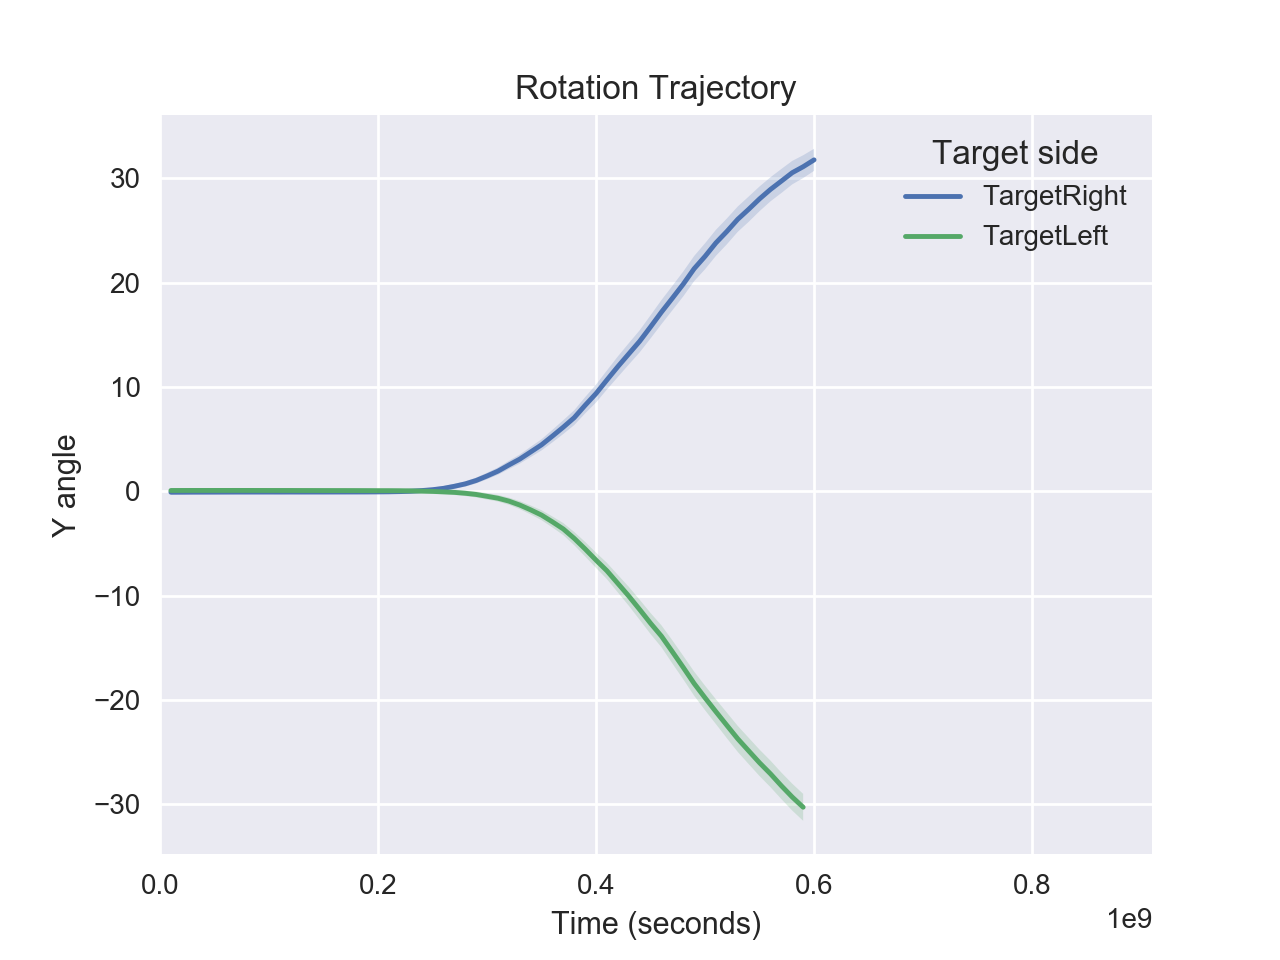

/Users/jessegeerts/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


In [797]:
fig = plt.figure()
ax = sns.tsplot(data=trajectories_df, time="Trial time", value='Y angle', unit='Trial number',condition='Target side')
plt.title('Rotation Trajectory')
plt.xlabel('Time (seconds)')
#plt.savefig('./Figures/rotation_trajectory.png')
plt.show()

### Now, lets have a look at the distribution of movement endpoints  in terms of Y angle and reaction times. 

In [720]:
# TODO: fix trial numbering system so this works
RT=[]
for i in trajectories_df['Trial number'].unique():
    idx = trajectories_df['Trial number'] == i
    RT.append(trajectories_df[idx]['Trial time'].max())

In [749]:
trials = pd.DataFrame(index=trajectories_df['Trial number'].unique(),
                      columns=['RT'],
                      data=np.array(np.array(RT)))
trials.index.name = 'Trial'

In [751]:
# add the target side info to this dataframe
trials['Target side'] = target_sides['Name']

In [778]:
trials['Reaction time (ms)']= trials['RT'].apply(lambda x: x.microseconds/1000)

<IPython.core.display.Javascript object>


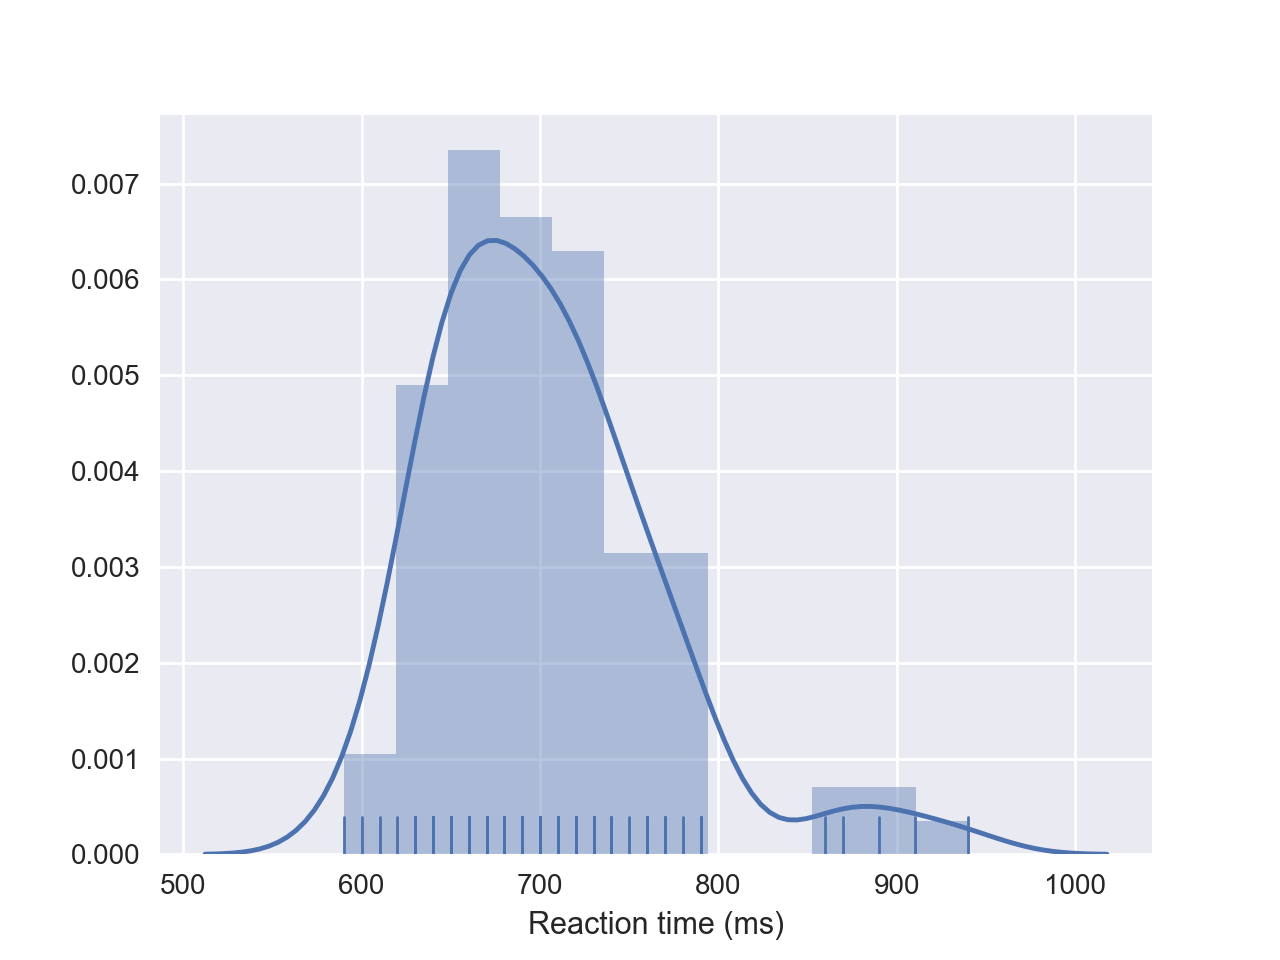

In [780]:
sns.distplot(trials['Reaction time (ms)'],rug=True)

<IPython.core.display.Javascript object>


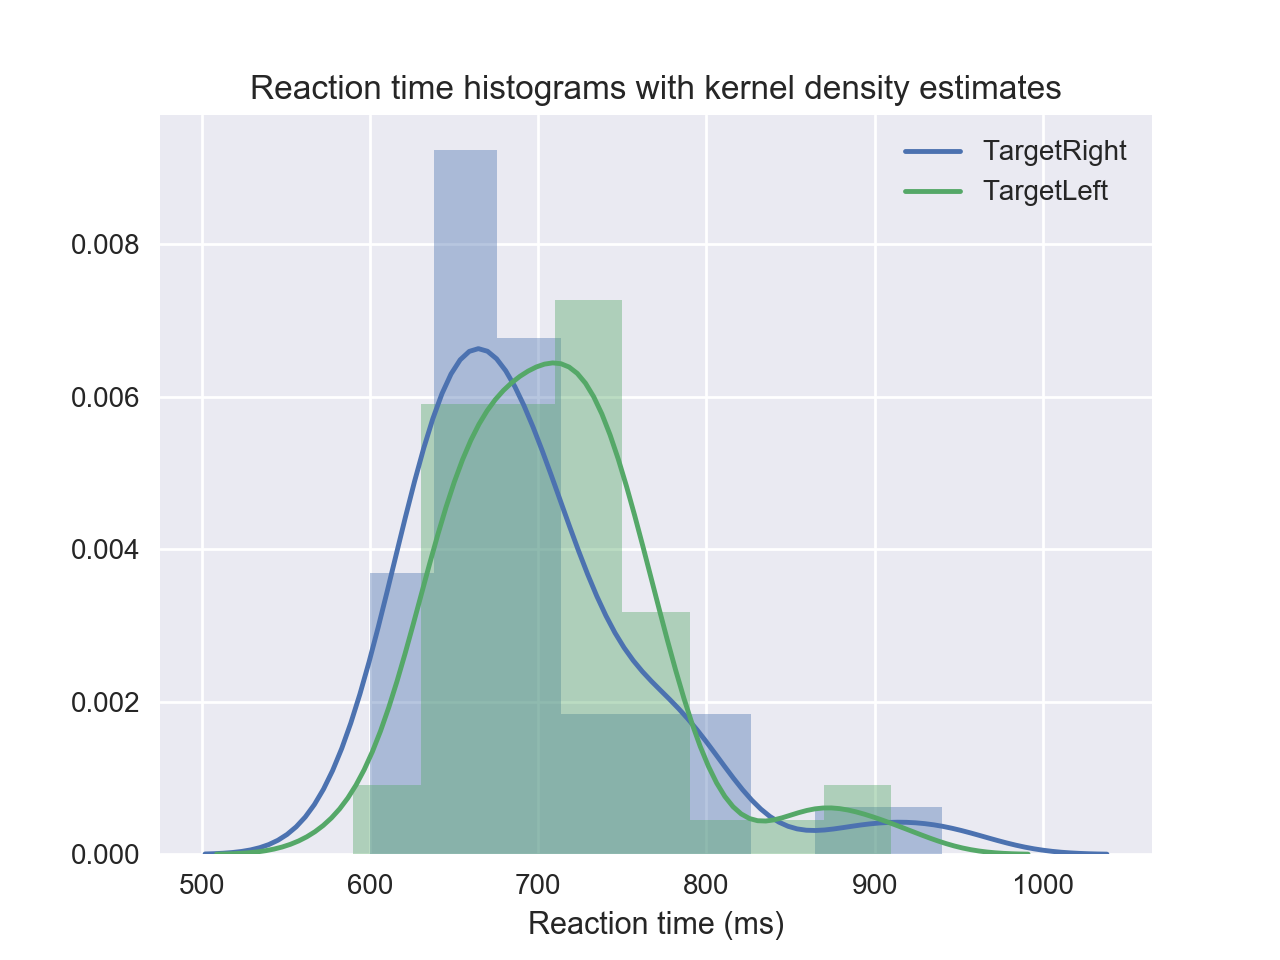

In [790]:
# plot left and right separately
sns.distplot(trials.loc[trials['Target side']=='TargetRight','Reaction time (ms)'],
             kde_kws={'label':'TargetRight'})
sns.distplot(trials.loc[trials['Target side']=='TargetLeft','Reaction time (ms)'],
             kde_kws={'label':'TargetLeft'})
plt.title('Reaction time histograms with kernel density estimates')
# in order to fit a normal distribution instead: >>> from scipy.stats import norm, then fit=norm as argument

<IPython.core.display.Javascript object>


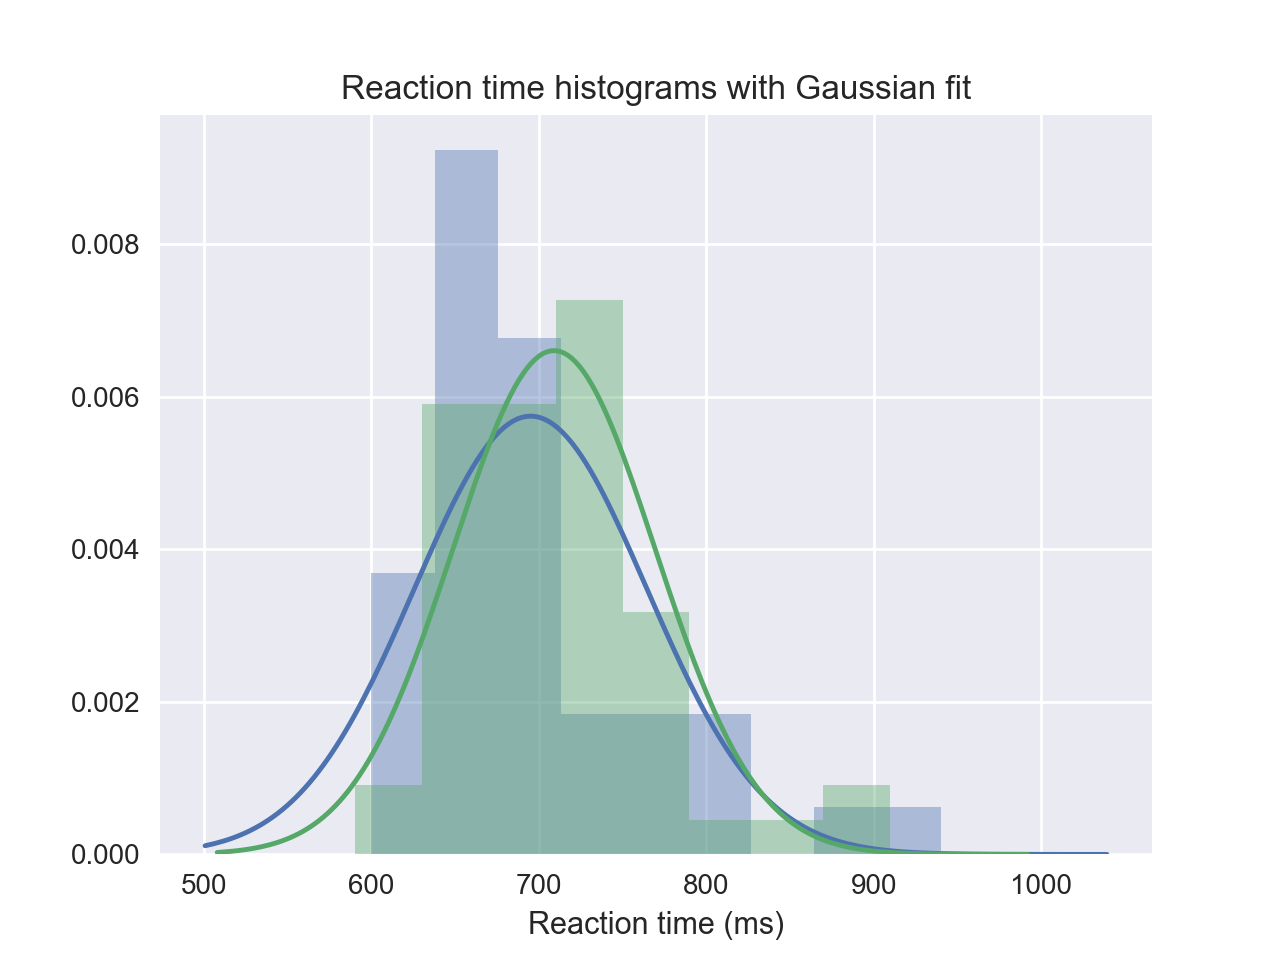

In [795]:
from scipy.stats import norm
# plot left and right separately
sns.distplot(trials.loc[trials['Target side']=='TargetRight','Reaction time (ms)'],
             kde=False,
             fit=norm,
             fit_kws={'color':'b','label':'TargetRight'},
             label='TargetRight')
sns.distplot(trials.loc[trials['Target side']=='TargetLeft','Reaction time (ms)'],
             kde=False,
             fit=norm,
             fit_kws={'color':'g','label':'TargetLeft'})
plt.title('Reaction time histograms with Gaussian fit')

### Distribution of movement endpoints

In [809]:
startpoints=[]
endpoints=[]
for i in trajectories_df['Trial number'].unique():
    idx = trajectories_df['Trial number'] == i
    startpoints.append(trajectories_df[idx].iloc[1]['Y angle'] )
    endpoints.append(trajectories_df[idx].iloc[-1]['Y angle'] )

In [810]:
trials['Starting points'] = startpoints

In [811]:
trials['Movement endpoints'] = endpoints

In [813]:
trials.head()

,RT,Target side,Reaction time,Reaction time (ms),Starting points,Movement endpoints
Trial,,,,,,
0,00:00:00.790000,TargetRight,790.0,790.0,-1.764072,34.398415
1,00:00:00.740000,TargetLeft,740.0,740.0,-1.393047,-41.487100
2,00:00:00.730000,TargetRight,730.0,730.0,-4.410033,34.799007
3,00:00:00.730000,TargetLeft,730.0,730.0,-4.252989,-35.469343
4,00:00:00.690000,TargetLeft,690.0,690.0,-3.285229,-41.280954


<IPython.core.display.Javascript object>


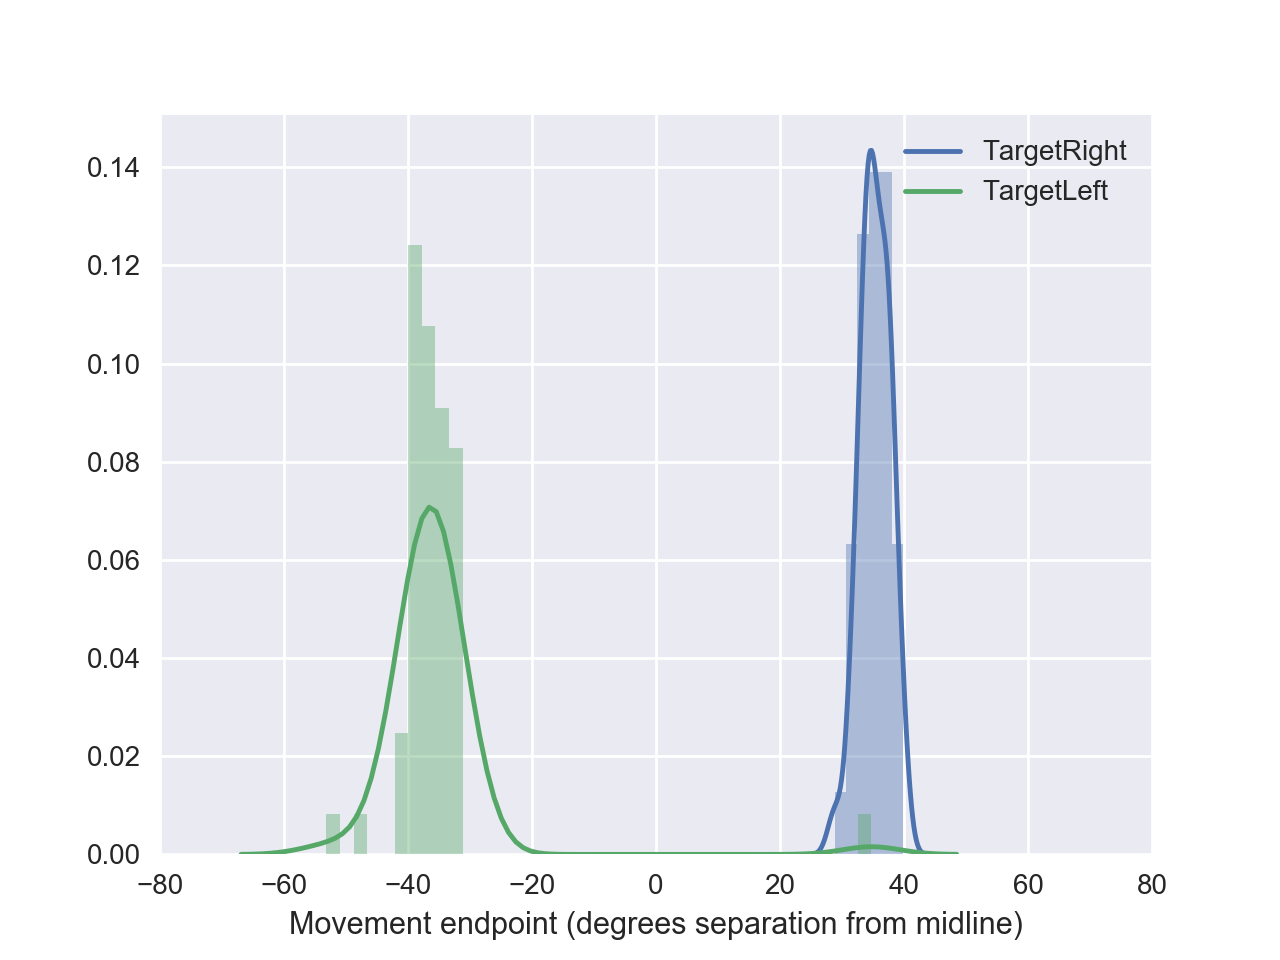

In [822]:
sns.distplot(trials.loc[trials['Target side']=='TargetRight','Movement endpoints'],
            kde_kws={'label':'TargetRight'})
sns.distplot(trials.loc[trials['Target side']=='TargetLeft','Movement endpoints'],
            kde_kws={'label':'TargetLeft'})
plt.xlim([-80,80])
plt.xlabel('Movement endpoint (degrees separation from midline)')

In [839]:
trial_results = ed[(ed['Name']=='Neutral') | (ed['Name']=='Missed') | (ed['Name']=='Hit') | (ed['Name']=='Penalty')]
trials['Outcome'] = np.array(trial_results['Name'])

In [841]:
trials.head()

,RT,Target side,Reaction time,Reaction time (ms),Starting points,Movement endpoints,Outcome
Trial,,,,,,,
0,00:00:00.790000,TargetRight,790.0,790.0,-1.764072,34.398415,Neutral
1,00:00:00.740000,TargetLeft,740.0,740.0,-1.393047,-41.487100,Hit
2,00:00:00.730000,TargetRight,730.0,730.0,-4.410033,34.799007,Hit
3,00:00:00.730000,TargetLeft,730.0,730.0,-4.252989,-35.469343,Neutral
4,00:00:00.690000,TargetLeft,690.0,690.0,-3.285229,-41.280954,Hit


In [864]:
mean_end_right = trials.loc[trials['Target side']=='TargetRight','Movement endpoints'].mean()
mean_end_left = trials.loc[trials['Target side']=='TargetLeft','Movement endpoints'].mean()